# Esame Probabilità e Statistica

24/06/2022

Maria Pasinetti, Francesco Villa

## Analisi dati

Svolgiamo una prima fase di analisi dati generica. Abbiamo a che fare con un data frame che contiene una serie di regioni in Europa (per esempio i Comuni di un determinato Paese), e alcuni parametri, tra cui in particolare le quantità di $CO_2$ emesse da diversi fattori. 

In [2]:
%matplotlib inline
import html5lib 
import plotly
import json
import folium
import openpyxl
import pandas as pd
import numpy as np
import scipy.stats 
import seaborn as sns
import matplotlib.pylab as plt
import networkx as nx
import plotly.graph_objects as go
from matplotlib import rcParams
from adjustText import adjust_text
from faker import Faker
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

In [3]:
# usiamo caratteri leggibili!
plt.rcParams.update({'font.size': 18})

In [4]:
df = pd.read_excel("../data/allcountries_onlycities_summary.xlsx", index_col=0)
data=pd.read_excel("../data/datachallenge.xlsx", index_col = 0)

In [5]:
df.head(5)

,Region Name,admin_level,Est. Population,Total (t CO2),CO2 per capita,airports,buildings,ets,farms,fuelstations,harbours,refineries,tiox,trains
Country,,,,,,,,,,,,,,
austria,Abtenau,8,5751.983761,60942,10.594953,0,47936,0,0,13006,0,0,0,0
austria,Adlwang,8,1675.468718,12852,7.670689,0,12096,0,756,0,0,0,0,0
austria,Admont,8,4913.904174,70007,14.246717,0,43456,0,99,26012,0,0,0,440
austria,Adnet,8,3302.772923,21881,6.625039,0,21728,0,153,0,0,0,0,0
austria,Aflenz,8,2434.512515,24039,9.874256,0,17536,0,0,6503,0,0,0,0


**Tab. 1:** Le prime 5 righe del nostro data frame.

In [6]:
paesi=data.groupby("Country").sum()

paesi=paesi["Total (t CO2)"]

## Mappa

Decidiamo di raggruppare il data frame per i diversi stati, e di dare una rappresentazione geografica dei contributi alle emissioni di CO2 dei Paesi europei.

In [7]:
m=folium.Map(location=[43, 12], zoom_start=4, titles="Carto0B position")

stati_json=folium.GeoJson("../data/statigeo.json").add_to(m)

folium.LayerControl().add_to(m)


with open("../data/statigeo.json") as f:
    stati_geojson = json.load(f)

for item in stati_geojson["features"]:
    item['stati'] = item['properties']['NAME']

data_popup=pd.read_excel("../data/dataset_popup.xlsx")

In [9]:
m=folium.Map(location=[43, 12], zoom_start=4, titles="Carto0B position")
folium.Choropleth(geo_data=stati_geojson, 
                  data=data_popup,
                  columns=["stato", "medie_CO2"], 
                  key_on="feature.stati", 
                  bins=9,
                  fill_color='RdYlGn_r',
                  nan_fill_color='white',
                  fill_opacity=0.6,
                  nan_fill_opacity=None,
                  line_color='black', 
                  line_weight=1, 
                  line_opacity=1, 
                  legend_name='Total CO2 emissions',
                  name="Toltal CO2 emission per state", 
                  overlay=True, 
                  control=True, 
                  show=True, 
                  topojson=None, 
                  smooth_factor=None, 
                  heighlight=None).add_to(m)

In [10]:
states=data_popup["stato"]
LAT=data_popup["lat"]
LONG=data_popup["long"]
medie_CO2=data_popup["medie_CO2"]

for stato, lat, long, medie_CO2 in zip(states, LAT, LONG, medie_CO2):
    folium.Marker(location=[lat, long], popup =stato + ": "+ str(medie_CO2)+ " Tonnellate", 
                  tooltip = " Emissioni totali CO2:",
                  icon= folium.Icon(color="green", icon="recycle", prefix="fa")).add_to(m)
    
m

**Map:** La mappa è color-coded a seconda delle emissioni totali di CO2 di ciascun Paese: il dataframe è stato raggruppato per Paesi ed è rappresentato su scala cromatica il valore complessivo di emissioni totali di ciascun Paese.

### Paesi

Una volta raggruppato il dataframe per ciascun Paese, eseguiamo una somma sui valori di tutte le colonne, in maniera da ottenere le emissioni totali per ciascuna delle cause di emissioni (aeroporti, edifici, industrie...) eccezion fatta per la colonna *"CO2 per capita mean"*, sulla quale riporteremo il rapporto tra la colonna contenente le emissioni totali di $CO_{2}$ e la popolazione complessiva stimata.

In [9]:
#Raggruppiamo:
df1 = df.drop(['admin_level', 'CO2 per capita'], 1)
paesi = df1.groupby("Country").sum()

#Opzione 2:
per_capita_mean = paesi['Total (t CO2)']/paesi['Est. Population']

paesi['CO2 per capita mean'] = per_capita_mean
paesi = paesi[['Est. Population', 'Total (t CO2)', 'CO2 per capita mean', 'airports', 'buildings', 'ets', 'farms', 'fuelstations', 'harbours', 'refineries', 'tiox', 'trains']]

#Medie e deviazione standard
medie = df.groupby("Country").mean()
dev = df.groupby("Country").std()

In [10]:
paesi.head(5)

,Est. Population,Total (t CO2),CO2 per capita mean,airports,buildings,ets,farms,fuelstations,harbours,refineries,tiox,trains
Country,,,,,,,,,,,,
austria,8.552469e+06,89331830,10.445151,2575940,32890048,29264865,1017261,23306752,56640,127264,0,93060
belgium,1.130188e+07,143122078,12.663569,5163671,36475024,43130688,2357696,24925120,27262608,3730782,0,76489
bulgaria,7.113659e+06,35285037,4.960181,824780,9356340,14685726,474144,9110745,87804,711550,0,33948
croatia,3.346881e+06,20569230,6.145790,591389,7839776,6452996,543105,4833270,46299,222135,0,40260
cyprus,5.460136e+05,2309744,4.230195,1038000,293120,0,8064,970560,0,0,0,0


**Tab. 2:** Le prime 5 righe del data frame raggruppato per Stati.

### Scatter plot

Riportiamo la distribuzione dei diversi Paesi a seconda del livello di emissioni di $CO_{2}$ per capita tramite uno scatter plot.

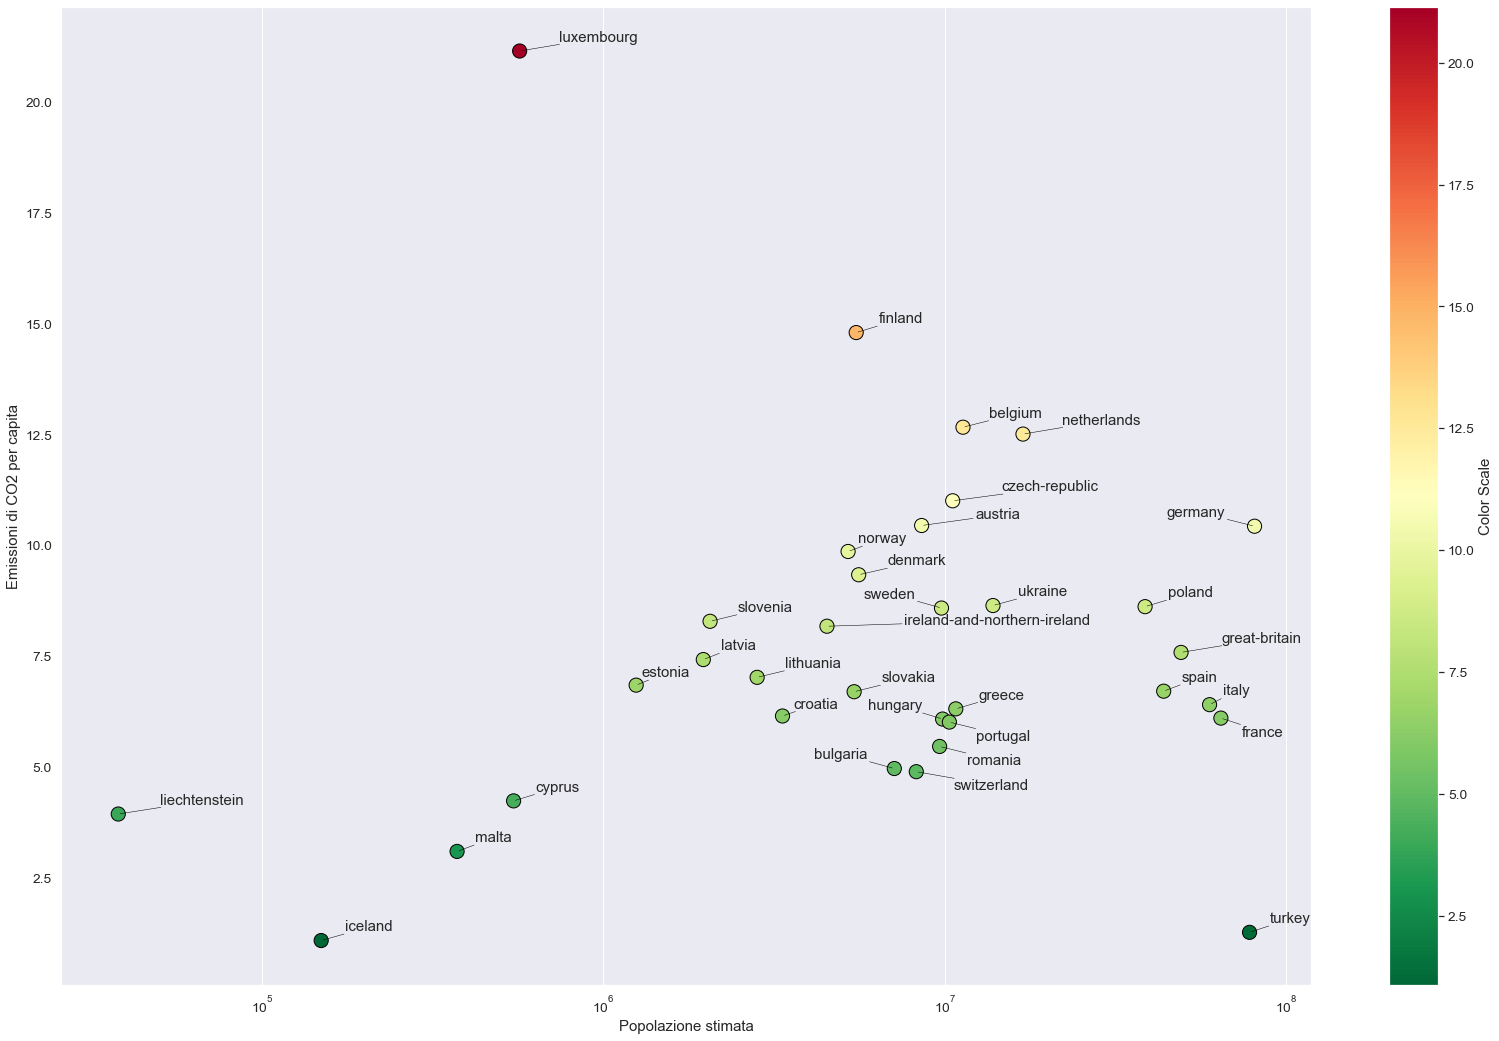

In [11]:
#paesi['label'] = ['AT', 'BE', 'BG', 'HR', 'CY', 'CZ', 'DK', 
#                  'EE', 'FI', 'FR', 'DE', 'GB', 'EL', 'HU', 
#                  'IS', 'IR', 'IT', 'LV', 'LI', 'LT', 'LU', 
#                  'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'SK', 
#                  'SI', 'ES', 'SE', 'CH', 'TU', 'UA']

sns.set(style="darkgrid")
sns.set(font_scale=1.25)

xs = paesi['Est. Population'].to_numpy()
ys = paesi['CO2 per capita mean'].to_numpy()
#labels = paesi.label
labels = paesi.index

fig = plt.figure(figsize=(28, 18))

ax = plt.axes()

scatter = plt.scatter(xs, ys, s=200, c=ys, edgecolors='black' , cmap=cm.get_cmap('RdYlGn_r'))

# colorscale
cb = fig.colorbar(scatter, ax=ax)
cb.set_label('Color Scale')
plt.xscale('log')

texts = []
for x, y, s in zip(xs, ys, labels):
    texts.append(plt.text(x, y, s))
    
adjust_text(texts, force_points=0.2, force_text=0.2,
        expand_points=(2, 2), expand_text=(1, 1),
        arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.xlabel("Popolazione stimata")
plt.ylabel("Emissioni di CO2 per capita")
plt.grid(axis = 'y')

plt.show()

**Fig. 1:** Nel grafico vengono riportati i diversi Paesi in uno scatter plot che mette in relazione la popolazione stimata del paese con le emissioni per capita di ciascun Paese. Non si nota alcun trend specifico nella distribuzione, ma è possibile notare che alcuni Paesi hanno dei valori ben lontani dalla media europea. Salta subito all'occhio il caso del **Lussemburgo**, che ha consumi per capita elevatissimi pur avendo una popolazione limitata; abbiamo una situazione opposta nel caso della **Turchia**, con popolazione elevata ma consumi per capita bassi.

### Massime e minime cause di emissione

Passiamo a chiederci quali siano, in generale, le cause primarie di emissioni di $CO_2$ per i diversi Paesi europei:

In [12]:
paesi = data.drop(['admin_level', 'CO2 per capita'], 1)
paesi=data.groupby("Country").sum()

per_capita_mean = paesi['Total (t CO2)']/paesi['Est. Population']


paesi['CO2 per capita mean'] = per_capita_mean
paesi = paesi[['Est. Population', 'Total (t CO2)', 'CO2 per capita mean', 'airports', 'buildings', 'ets', 'farms', 'fuelstations', 'harbours', 'refineries', 'tiox', 'trains']]

df1 = paesi.drop(['Est. Population', 'Total (t CO2)', 'CO2 per capita mean', 'tiox'], 1)
max_cause = df1.idxmax(axis=1)
paesi['max. cause'] = max_cause
min_cause = df1.idxmin(axis=1)
paesi['min. cause'] = min_cause

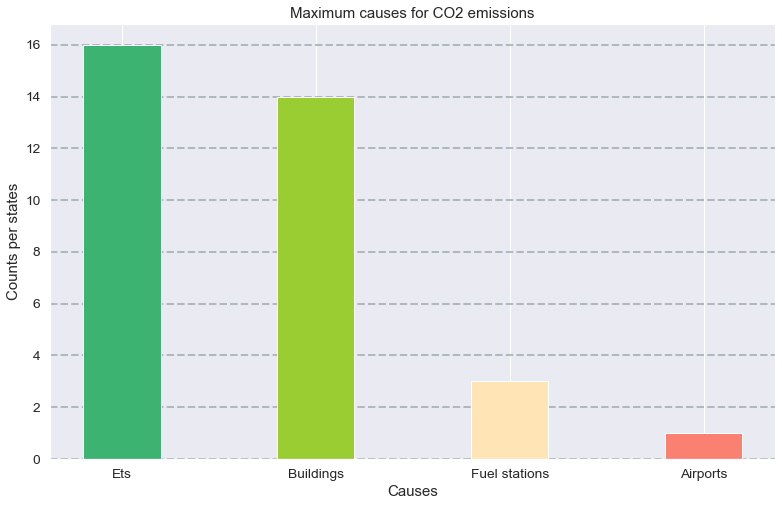

In [13]:
valori_bar={'Ets':16, 'Buildings':14, 'Fuel stations':3,
        'Airports':1}

courses = list(valori_bar.keys())
values = list(valori_bar.values())
  
fig = plt.figure(figsize = (13, 8))
colors = ['mediumseagreen', 'yellowgreen', 'moccasin', 'salmon']
# creating the bar plot
plt.bar(courses, values, color =colors,
        width = 0.4)
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.xlabel("Causes")
plt.ylabel("Counts per states")
plt.title("Maximum causes for CO2 emissions")
plt.show()

In **Fig.2** è rappresentato un barplot dove risulta evidente come la maggiore causa dell'emissione di $ CO_2 $ per Paese siano le *Industries Facilities*, seguite dagli edifici. 

## Boxplot - città più o meno popolose

Proviamo a confrontare le emissioni per capita di Italia, Spagna e Turchia: vogliamo vedere cosa succede se separiamo il dataset a seconda della popolazione stimata di ogni *regione*. In particolare questo corrisponde a plottare le emissioni per capita dei tre Paesi, separando le città popolose da quelle meno popolose. Svolgiamo quest'operazione 3 volte, cambiando il parametro a seconda del quale si considerino "città popolose" o meno. I tre valori che abbiamo scelto sono:
1. Popolazione maggiore di 10.000 abitanti;
2. Popolazione maggiore di 50.000 abitanti;
3. Popolazione maggiore di 300.000 abitanti.

In [14]:
#Inseriamo colonna log(CO2 per capita
dff = df[df['CO2 per capita'] > 0]
dff["log(CO2 per capita)"]=np.log(dff["CO2 per capita"])

[Text(0.5, 1.0, ''), Text(0, 0.5, ''), Text(0.5, 0, '')]

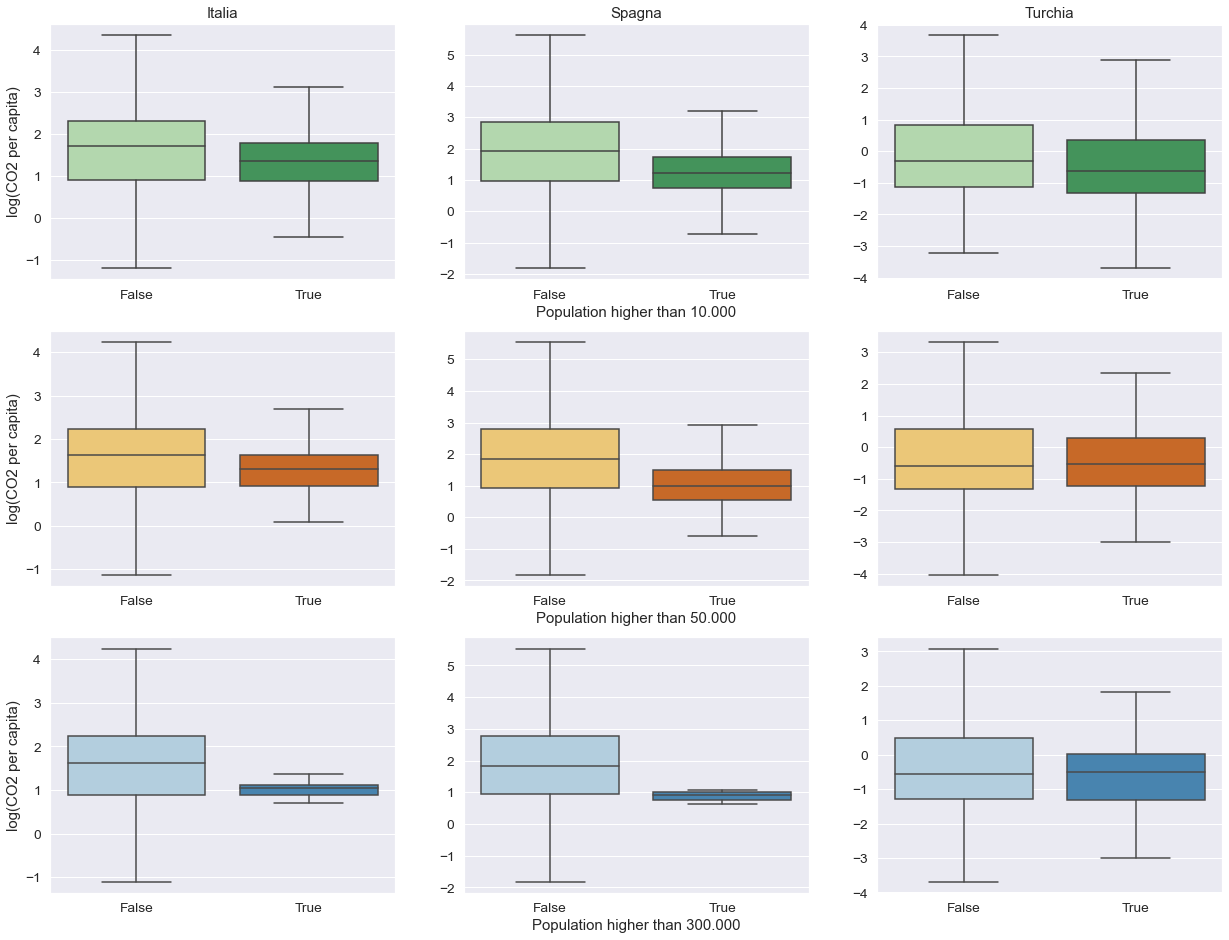

In [15]:
rcParams['figure.figsize'] = 21, 16
sns.set(style="darkgrid")
sns.set(font_scale=1.25)

#Inseriamo colonna log(CO2 per capita)
dff = df[df["CO2 per capita"] != 0]
dff["log(CO2 per capita)"]=np.log(dff["CO2 per capita"])

# Classifichiamo i Comuni a seconda della popolazione
dff["Population High"]=(dff["Est. Population"]>1e4)

# Italia
italia = dff.loc["italy"]
# Turchia
turchia = dff.loc["turkey"]
# Spagna
spagna = dff.loc["spain"]


fig, axs = plt.subplots(ncols=3, nrows=3)
ax = sns.boxplot(data=italia, x="Population High", y="log(CO2 per capita)", ax = axs[0,0], showfliers = False, palette="Greens")
ax.set(title='Italia', xlabel = '')
#ax.set(yscale="log")
ax = sns.boxplot(data=spagna, x="Population High", y="log(CO2 per capita)", ax = axs[0,1], showfliers = False, palette="Greens")
ax.set(title='Spagna', xlabel = 'Population higher than 10.000', ylabel = '')
#ax.set(yscale="log")
ax = sns.boxplot(data=turchia, x="Population High", y="log(CO2 per capita)", ax = axs[0,2], showfliers = False, palette="Greens")
ax.set(title='Turchia', ylabel = '', xlabel = '')
#ax.set(yscale="log")

# Classifichiamo i Comuni a seconda della popolazione
dff["Population High"]=(dff["Est. Population"]>5e4)

# Italia
italia = dff.loc["italy"]
# Turchia
turchia = dff.loc["turkey"]
# Spagna
spagna = dff.loc["spain"]

ax = sns.boxplot(data=italia, x="Population High", y="log(CO2 per capita)", ax = axs[1,0], showfliers = False, palette="YlOrBr")
ax.set(title='', xlabel = '')
#ax.set(yscale="log")
ax = sns.boxplot(data=spagna, x="Population High", y="log(CO2 per capita)", ax = axs[1,1], showfliers = False, palette="YlOrBr")
ax.set(title='', xlabel = 'Population higher than 50.000', ylabel = '')
#ax.set(yscale="log")
ax = sns.boxplot(data=turchia, x="Population High", y="log(CO2 per capita)", ax = axs[1,2], showfliers = False, palette="YlOrBr")
ax.set(title='', ylabel = '', xlabel = '')
#ax.set(yscale="log")

# Classifichiamo i Comuni a seconda della popolazione
dff["Population High"]=(dff["Est. Population"]>3e5)

# Italia
italia = dff.loc["italy"]
# Turchia
turchia = dff.loc["turkey"]
# Spagna
spagna = dff.loc["spain"]

ax = sns.boxplot(data=italia, x="Population High", y="log(CO2 per capita)", ax = axs[2,0], showfliers = False, palette="Blues")
ax.set(title='', xlabel = '')
#ax.set(yscale="log")
ax = sns.boxplot(data=spagna, x="Population High", y="log(CO2 per capita)", ax = axs[2,1], showfliers = False, palette="Blues")
ax.set(title='', xlabel = 'Population higher than 300.000', ylabel = '')
#ax.set(yscale="log")
ax = sns.boxplot(data=turchia, x="Population High", y="log(CO2 per capita)", ax = axs[2,2], showfliers = False, palette="Blues")
ax.set(title='', ylabel = '', xlabel = '')
#ax.set(yscale="log")

**Fig.3:** Nella figura sono mostrati i boxplot effettuati per tre diversi Paesi quali Italia, Turchia e Spagna. Sull'asse delle ascisse è presente la popolazione, mentre sull'asse delle ordinate sono presenti le emissioni totali di $CO_2$ per comune. 

Contrariamente a quanto ci aspettavamo, risulta che le città meno popolose hanno un'incidenza maggiore per quanto riguarda le emissioni per capita - la mediana per le città meno popolose è più elevata rispetto alla mediana per le città più popolose: queste ultime risultano in questo senso "più sostenibili". Questo discorso è valido per tutti e tre i Paesi nel caso in cui si considerino "più popolose", città sopra la soglia dei 10.000 abitanti. Andando ad aumentare tale soglia si nota che, mentre per Italia e Spagna, che si comportano in modo analogo, l'effetto osservato si accentua, nel caso della Turchia l'effetto si inverte, e risulta che, per soglie di 50.000 e 300.000 abitanti, le città popolose hanno emissioni per capita più elevate.

## Analisi della correlazione

E' possibile chiedersi quali possano essere le grandezze maggiormente correlate. 
Ci aspettiamo che le grandezze maggiormente correlate risultino essere le emissioni di CO2 totali e la popolazione, o la presenza di industrie (ricordiamo che il parametro ets era per la maggior parte dei Paesi europei il fattore più influente sulle emissioni totali di CO2 del Paese). Quindi tramite la creazione di una matrice di correlazione si cerca di verificare questa ipotesi. 

### Matrice di correlazione

<Figure size 1440x1080 with 0 Axes>

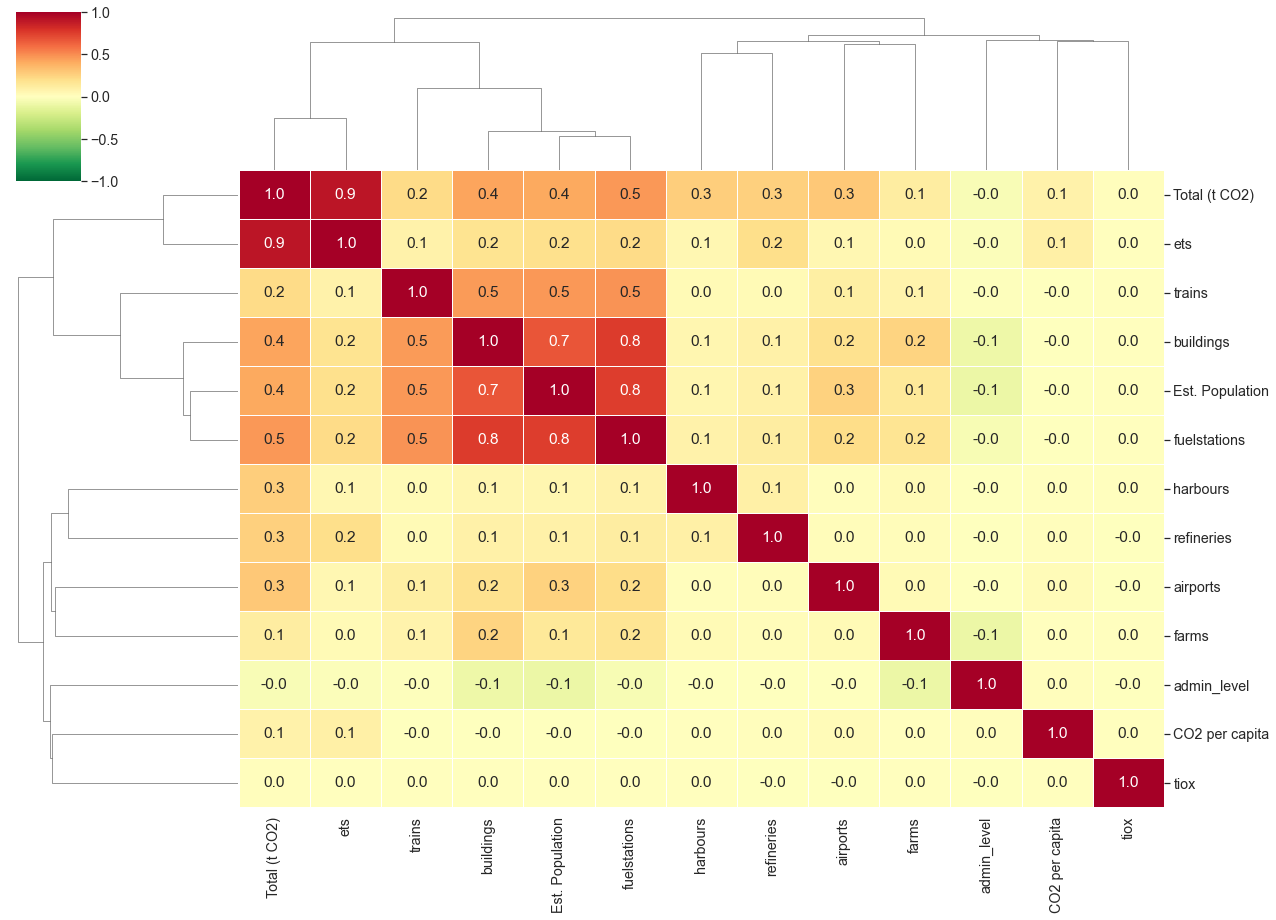

In [16]:
plt.rcParams.update({'font.size': 16})
data_states=data.groupby("Country")
fig= plt.figure(figsize=(20, 15))
sns.set(font_scale=1.3)


correlation=data.corr('pearson')

sns.clustermap(correlation, vmin=-1, vmax=1, 
               figsize=(18, 13),
               cmap="RdYlGn_r", 
               fmt=".1f",
               annot=True, 
               linewidths=.5)

La **Fig. 4** fornisce un riscontro grafico della correlazione tra le grandezze presenti nel dataset. La matrice è stata effettuata con un metodo di correlazione lineare detto metodo *Pearson*.
Si può notare come l'ipotesi fatta in precedenza risulti in parte verificata: si mostra infatti come la maggior correlazione si riscontra tra le emissioni di CO2 totali e *Industrial facilities*, e riscontriamo un buon grado di correlazione con la popolazione. Inoltre, le altre grandezze maggiormente correlate risultano le emissioni di edifici, di stazioni di rifornimento e la stima della popolazione.

### Network

Un altro metodo di visualizzazione grafica delle correlazioni tra le variabili considerate,
è la creazione e la stampa di un Network. 

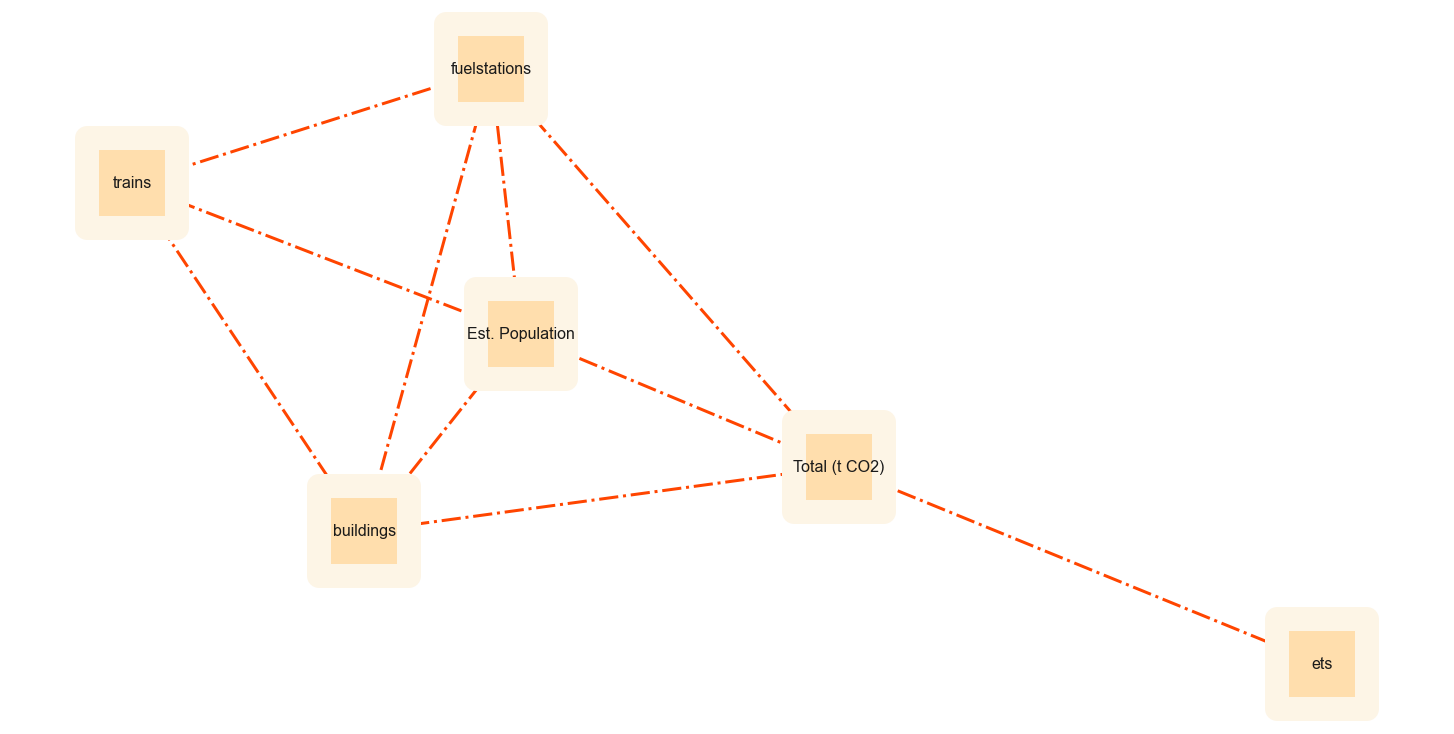

In [17]:
import pylab

corr=data.corr(method='pearson')

links = corr.stack().reset_index()
links.columns = ['x1', 'x2','x']
links_filtered=links.loc[ (links['x'] > 0.4) & (links['x1'] != links['x2']) ]

links
G = nx.DiGraph()
G=nx.from_pandas_edgelist(links_filtered, 'x1', 'x2')

red_edges = [('ets','Total (t CO2)')]
edge_colors = ['red' if not edge in red_edges else 'black' for edge in G.edges()]
edge_widths = [ 3]

edge_colors = ['orangered']
fig = plt.figure(figsize=(20, 10))
nx.draw(G, with_labels=True, 
        node_color="navajowhite", 
        node_size=8000,
        edgecolors='oldlace',
        linewidths=24, 
        font_size=16,
        alpha=1,
        style="dashdot",
        node_shape="s",
        arrowstyle="CurveAB",
        edge_color=edge_colors, 
        width=edge_widths
       )

pylab.show()

La **Fig. 5** presenta un riscontro grafico del network generato a partire dalle grandezze presenti nel dataset correlate linearmente, utilizzando come valore discriminante 0.4. Quindi si nota come le industrie siano legate solo alle emissioni di CO2 totali, mentre la popolazione risulta legata ad altri 3 fattori quali stazioni di rifornimento, treni ed edifici.

## Massima Verosimiglianza

Ci serviamo del metodo di massima verosimiglianza per cercare di effettuare un fit sulla distribuzione dei valori di emissione di CO2.

Riportiamo in grafico:
- la distribuzione di emissioni totali dell'intero data frame, il suo fit ottenuto con MLE, e le rispettive distribuzioni cumulate;
- la distribuzione di emissioni per capita dell'intero data frame, il suo fit ottenuto con MLE, e le rispettive distribuzioni cumulate;

Nell'analisi della distribuzione di emissioni per capita abbiamo trovato opportuno escludere il caso del Lussemburgo, che rappresenta un'anomalia per quanto riguarda i consumi per capita rispetto alla media europea (rimandiamo allo scatter plot iniziale che rappresentava emissioni per capita rispetto alla popolazione).

### Istogrammi, fit e cumulate delle emissioni di CO2 totali e per capita:

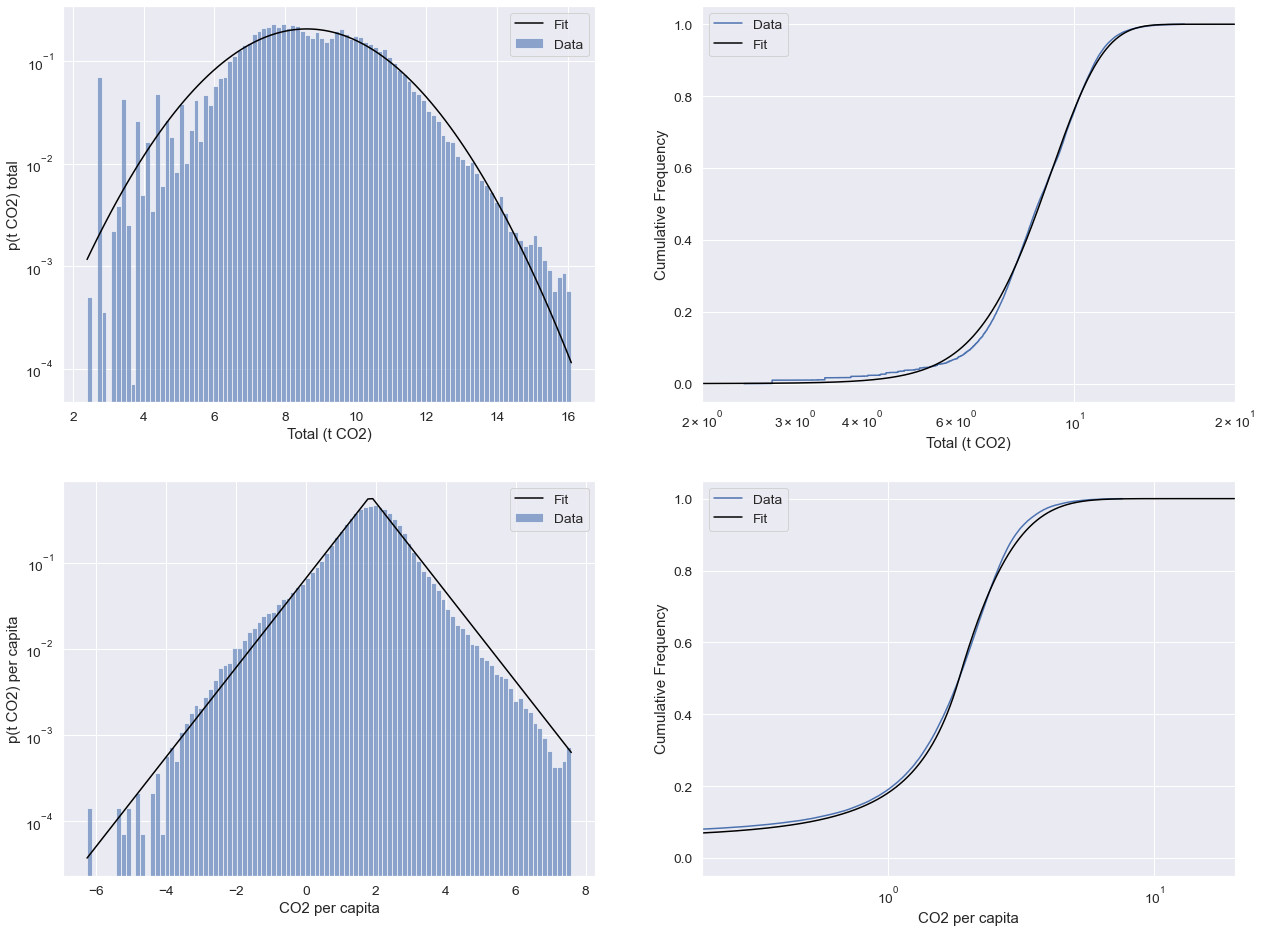

In [18]:
sns.set(font_scale=1.25)
fig, axs = plt.subplots(2, 2)

dff = df[df['Total (t CO2)'] < 1e7]
T_CO2 = dff["Total (t CO2)"]
T_CO2 = T_CO2[T_CO2 != 0]
T_CO2_log = np.log(T_CO2)

xmin=np.min(T_CO2_log)
xmax=np.max(T_CO2_log)
x1 = np.linspace(xmin,xmax,101)

dff_pc = df[df['CO2 per capita'] > 0]
dff_pc = df[df['CO2 per capita'] < 2000]
CO2_pc = dff_pc["CO2 per capita"]
CO2_pc = CO2_pc[CO2_pc != 0]

CO2_pc_log = np.log(CO2_pc)

xmin=np.min(CO2_pc_log)
xmax=np.max(CO2_pc_log)
x3 = np.linspace(xmin,xmax,101)

# Istogrammi e fit

# tot
ax1=axs[0, 0].hist(T_CO2_log, bins=100, density=True, label='Data', log = True, alpha = 0.6)
x_0=scipy.stats.norm.fit(T_CO2_log)
W=scipy.stats.norm(x_0[0], x_0[1]) 
ax1_fit=axs[0, 0].plot(x1, W.pdf(x1), label="Fit", color="black")
axs[0, 0].legend(loc='upper right')
axs[0, 0].set_xlabel('Total (t CO2)')
axs[0, 0].set_ylabel('p(t CO2) total')

# pro cap
ax3=axs[1, 0].hist(CO2_pc_log, bins=100, density=True, label='Data', log = True, alpha = 0.6)
x_1=scipy.stats.laplace.fit(CO2_pc_log)
W_pc=scipy.stats.laplace(x_1[0], x_1[1]) 
ax3_fit=axs[1, 0].plot(x3, W_pc.pdf(x3), label="Fit", color="black")
axs[1, 0].legend(loc='upper right')
axs[1, 0].set_xlabel('CO2 per capita')
axs[1, 0].set_ylabel('p(t CO2) per capita')

# Cumulate

X_1 = np.linspace(10**(-2), 1e4,num=1000000)
y1=np.sort(T_CO2_log)
idx1 = [ i/len(y1) for i in range(len(y1))]
axs[0, 1].set_xlabel('Total (t CO2)')
axs[0, 1].set_ylabel('Cumulative Frequency')
axs[0, 1].plot(y1,idx1,label="Data")
axs[0, 1].plot(X_1, W.cdf(X_1), label="Fit", color="black")
axs[0, 1].set_xscale('log')
axs[0, 1].set_xlim(2e0, 2e1)
axs[0, 1].legend()

X_4 = np.linspace(10**(-2), 1e4,num=1000000)
y4=np.sort(CO2_pc_log)
idx4 = [ i/len(y4) for i in range(len(y4))]
axs[1, 1].set_xlabel('CO2 per capita')
axs[1, 1].set_ylabel('Cumulative Frequency')
axs[1, 1].plot(y4,idx4,label="Data")
axs[1, 1].plot(X_4, W_pc.cdf(X_4), label="Fit", color="black")
axs[1, 1].set_xscale('log')
axs[1, 1].set_xlim(2e-1, 2e1)
axs[1, 1].legend()

**Fig.6:** Nel caso dell'istogramma delle emissioni totali (grafico in alto a sinistra), si può notare la possibile presenza di due picchi separati. Cerchiamo di risolvere la separazione dei due picchi, e decidiamo di separare il dataframe a seconda dei due parametri che riteniamo più rilevanti, perché significativamente correlati alle emissioni di CO2 totali: 
1. Le *industrial facilities* (ets);
2. La popolazione stimata.

Nonostante l'accordo non ottimale tra istogramma e fit, l'accordo per la distribuzione cumulata risulta migliore. 

### Istogrammi, fit e cumulate delle emissioni di CO2 totali, separando il dataset per valori di ets e Est. Population:

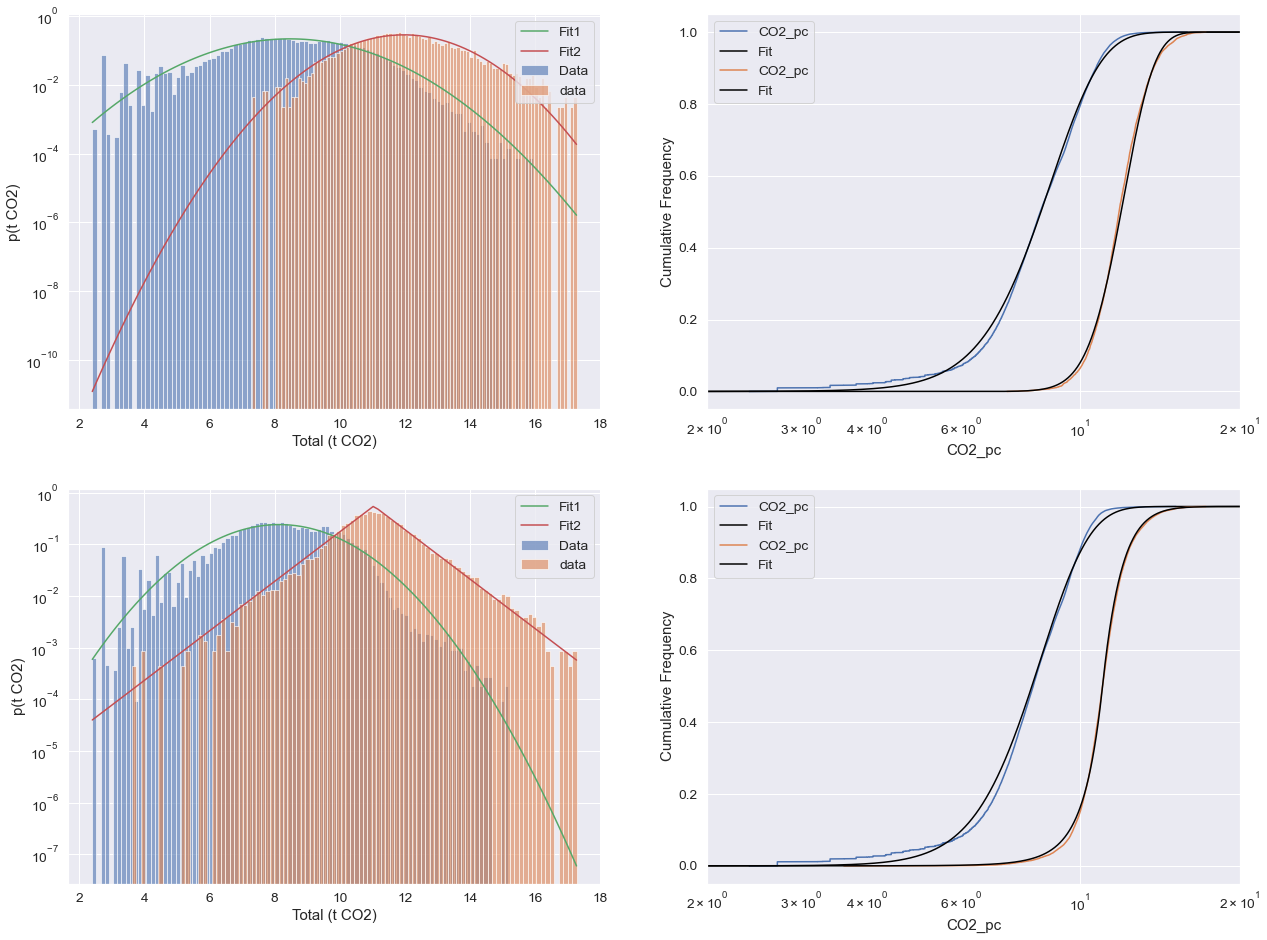

In [19]:
fig, axs = plt.subplots(2, 2)

# Istogrammi e fit

# totali separati per ets

ets = df
ets = ets[ets['CO2 per capita'] < 2000]
ets["ets high"]=(ets["ets"]>0)

ets_0 = ets[ets["ets high"] == False]
ets_1 = ets[ets["ets high"] == True]

T_CO2_0 = ets_0["Total (t CO2)"]
T_CO2_1 = ets_1["Total (t CO2)"]

T_CO2_0 = T_CO2_0[T_CO2_0 != 0]
T_CO2_1 = T_CO2_1[T_CO2_1 != 0]

T_CO2_0_log = np.log(T_CO2_0)
T_CO2_1_log = np.log(T_CO2_1)

xmin4=np.min(T_CO2_0_log)
xmax4=np.max(T_CO2_1_log)
x4 = np.linspace(xmin4,xmax4,101)

ax4_0=axs[0, 0].hist(T_CO2_0_log, bins=100, density=True, label='Data', log = True, alpha = 0.6)
ax4_1=axs[0, 0].hist(T_CO2_1_log, bins=100, density=True, label='data', log = True, alpha = 0.6)

x_2_0=scipy.stats.norm.fit(T_CO2_0_log)
x_2_1=scipy.stats.norm.fit(T_CO2_1_log)

W_0=scipy.stats.norm(x_2_0[0], x_2_0[1]) 
W_1=scipy.stats.norm(x_2_1[0], x_2_1[1]) 

axs[0, 0].plot(x4, W_0.pdf(x4), label="Fit1")
axs[0, 0].plot(x4, W_1.pdf(x4), label="Fit2")

axs[0, 0].legend(loc='upper right')
axs[0, 0].set_xlabel('Total (t CO2)')
axs[0, 0].set_ylabel('p(t CO2)')

# totali separati per popolazione

pop = df
pop = pop[pop['CO2 per capita'] < 2000]
mean = pop["Est. Population"].mean()
pop["pop high"]=(pop["Est. Population"] > mean)

pop_l = pop[pop["pop high"] == False]
pop_h = pop[pop["pop high"] == True]

T_CO2__0 = pop_l["Total (t CO2)"]
T_CO2__1 = pop_h["Total (t CO2)"]

T_CO2__0 = T_CO2__0[T_CO2__0 != 0]
T_CO2__1 = T_CO2__1[T_CO2__1 != 0]

T_CO2_0__log = np.log(T_CO2__0)
T_CO2_1__log = np.log(T_CO2__1)

xmin5=np.min(T_CO2_0__log)
xmax5=np.max(T_CO2_1__log)
x5 = np.linspace(xmin5,xmax5,101)

ax5_0=axs[1, 0].hist(T_CO2_0__log, bins=100, density=True, label='Data', log = True, alpha = 0.6)
ax5_1=axs[1, 0].hist(T_CO2_1__log, bins=100, density=True, label='data', log = True, alpha = 0.6)
x_3_0=scipy.stats.norm.fit(T_CO2_0__log)
x_3_1=scipy.stats.laplace.fit(T_CO2_1__log)

W__0=scipy.stats.norm(x_3_0[0], x_3_0[1]) 
W__1=scipy.stats.laplace(x_3_1[0], x_3_1[1]) 

axs[1, 0].plot(x5, W__0.pdf(x4), label="Fit1")
axs[1, 0].plot(x5, W__1.pdf(x4), label="Fit2")

axs[1, 0].legend(loc='upper right')
axs[1, 0].set_xlabel('Total (t CO2)')
axs[1, 0].set_ylabel('p(t CO2)')

# cumulate per ets

X_0 = np.linspace(10**(-2), 1e4,num=1000000)
y0=np.sort(T_CO2_0_log)
idx0 = [ i/len(y0) for i in range(len(y0))]
axs[0, 1].set_xlabel('CO2_pc')
axs[0, 1].set_ylabel('Cumulative Frequency')
axs[0, 1].plot(y0,idx0,label="CO2_pc")
axs[0, 1].plot(X_0, W_0.cdf(X_0), label="Fit", color="black")
axs[0, 1].set_xscale('log')
axs[0, 1].set_xlim(2e0, 2e1)
axs[0, 1].legend()

X_1 = np.linspace(10**(-2), 1e4,num=1000000)
y1=np.sort(T_CO2_1_log)
idx1 = [ i/len(y1) for i in range(len(y1))]
axs[0, 1].set_xlabel('CO2_pc')
axs[0, 1].set_ylabel('Cumulative Frequency')
axs[0, 1].plot(y1,idx1,label="CO2_pc")
axs[0, 1].plot(X_1, W_1.cdf(X_1), label="Fit", color="black")
axs[0, 1].set_xscale('log')
axs[0, 1].set_xlim(2e0, 2e1)
axs[0, 1].legend()

# cumulate per pop

X__0 = np.linspace(10**(-2), 1e4,num=1000000)
y_0=np.sort(T_CO2_0__log)
idx_0 = [ i/len(y_0) for i in range(len(y_0))]
axs[1, 1].set_xlabel('CO2_pc')
axs[1, 1].set_ylabel('Cumulative Frequency')
axs[1, 1].plot(y_0,idx_0,label="CO2_pc")
axs[1, 1].plot(X__0, W__0.cdf(X__0), label="Fit", color="black")
axs[1, 1].set_xscale('log')
axs[1, 1].set_xlim(2e0, 2e1)
axs[1, 1].legend()

X__1 = np.linspace(10**(-2), 1e4,num=1000000)
y_1=np.sort(T_CO2_1__log)
idx_1 = [ i/len(y_1) for i in range(len(y_1))]
axs[1, 1].set_xlabel('CO2_pc')
axs[1, 1].set_ylabel('Cumulative Frequency')
axs[1, 1].plot(y_1,idx_1,label="CO2_pc")
axs[1, 1].plot(X__1, W__1.cdf(X__1), label="Fit", color="black")
axs[1, 1].set_xscale('log')
axs[1, 1].set_xlim(2e0, 2e1)
axs[1, 1].legend()

Nella **Fig. 8** notiamo che le distribuzioni scelte non sembrano seguire bene l'andamento dell'istogramma e ci aspettiamo, dunque, che i test statistici rivelino una generale incompatibilità con le distribuzioni reali. Procediamo con il calcolo del p-value, aspettandoci che esso risulti più accettabile per le distribuzioni arancioni, visto che notiamo migliore aderenza nelle loro distribuzioni cumulate.

Non potendo assumere con certezzale distribuzioni delle emissioni ricavate in precedenza, è stato applicato il test di Kolmogorov-Smirnov per verificare il p-value tra dati e fit. Assumiamo la significatività $\alpha = 0.01$.

In [20]:
ets0 = scipy.stats.kstest(T_CO2_0_log, 'norm', N=len(T_CO2_0_log), args=(x_2_0[0], x_2_0[1]))
ets1 = scipy.stats.kstest(T_CO2_1_log, 'norm', N=len(T_CO2_1_log), args=(x_2_1[0], x_2_1[1]))

pop0 = scipy.stats.kstest(T_CO2_0__log, 'norm', N=len(T_CO2_0__log), args=(x_3_0[0], x_3_0[1]))
pop1 = scipy.stats.kstest(T_CO2_1__log, 'laplace', N=len(T_CO2_1__log), args=(x_3_1[0], x_3_1[1]))

print('Test Gaussiana per primo set di dati separati per ets:'), print(ets0)
print(' ')
print('Test Gaussiana per secondo set di dati separati per ets:'), print(ets1)
print(' ')
print('---------------------------------------------------------------------------')
print(' ')
print('Test Gaussiana per primo set di dati separati per popolazione:'), print(pop0)
print(' ')
print('Test Laplace per secondo set di dati separati per popolazione:'), print(pop1)

Test Gaussiana per primo set di dati separati per ets:
KstestResult(statistic=0.03154476158093478, pvalue=3.822500045663713e-85)
 
Test Gaussiana per secondo set di dati separati per ets:
KstestResult(statistic=0.035732207444481245, pvalue=2.0683393907186066e-05)
 
---------------------------------------------------------------------------
 
Test Gaussiana per primo set di dati separati per popolazione:
KstestResult(statistic=0.04154067948951046, pvalue=3.492921740307125e-129)
 
Test Laplace per secondo set di dati separati per popolazione:
KstestResult(statistic=0.020071212675585356, pvalue=3.0412419215145417e-06)


(None, None)

Dal test di Kolmogorov-Smirnof per le emissioni di  $CO_2$  totali, risultano dei p-value molto bassi (dell'ordine di  $10^{-5}$) per tutte le distribuzioni impiegate; questo indica che dobbiamo rigettare l'ipotesi che tali emissioni seguano queste distribuzioni. Anche per le emissioni di $CO_2$ pro capite possiamo rigettare l'ipotesi nulla che l'andamento segua le distribuzioni studiate.

# Conclusioni

Per concludere, l'analisi del dataset ha evidenziato come i Comuni maggiormente sostenibili a livello europeo siano quelli maggiormemnte popolosi, mentre quelli meno popolosi hanno una produzione di $CO_2$ per abitante maggiore. Inoltre, la  maggiore causa delle emissioni totali di $ CO_2 $ nella maggior parte dei Paesi europei risultano essere le *Industries facilities*. 

Dopodiché è stata effettuata un'analisi di correlazione ed un network, che hanno evidenziato la correlazione lineare tra *Industrial facilities* ed emissioni totali di $CO_2$ e un accettabile grado di correlazione con la popolazione stimata. 

In seguito abbiamo effettuato un'analisi statistica sfruttando il principio di massima verosimiglianza: abbiamo ottenuto una distribuzione di emissioni totali che mostrava la presenza di due picchi distinti, e abbiamo segmentato il dataset nel cercare di risolvere i due picchi. 

I test statistici che abbiamo effettuato in seguito ci consentono di rigettare l'ipotesi che l'andamento segua le distribuzioni studiate.